This notebook follows the tutorial here: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

Penn-Fudan Database for Pedestrian Detection and Segmentation: https://www.cis.upenn.edu/~jshi/ped_html/

In [1]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
#         masks = torch.as_tensor(masks, dtype=torch.uint8)

#         image_id = torch.tensor([idx])
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
#         iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
#         target["masks"] = masks
#         target["image_id"] = image_id
#         target["area"] = area
#         target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [5]:
import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [6]:
dataset = PennFudanDataset('./PennFudanPed', get_transform(train=False))

In [7]:
batch_size = 2
iterations = int(len(dataset)/batch_size) #chose 1411 so we can divide dataset by batch_size=32 evenly
num_epochs = 10

model = model.to(device)
model.train() #not needed?

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)


for epoch in range(num_epochs):
    print('starting epoch {}'.format(epoch))
    for it in range(iterations):
        if it%10 == 0:
            print('batch {}/{}'.format(it,iterations))
        #get batch data
        #faster r-cnn expects 2 inputs: a list of images and a list of target dictionaries
        images = []
        targets = []
        for b in range(batch_size*it,batch_size*(it+1)):
            img, t = dataset[b]
            images.append(img.to(device))
#             images.append(img)
            t['boxes'] = t['boxes'].to(device) #have to convert the target dictionary to gpu
            t['labels'] = t['labels'].to(device)
            targets.append(t)
            
        #forward pass through model and backprop
        '''
        follows the same logic as train_one_epoch() found here:
        https://github.com/pytorch/vision/blob/main/references/detection/engine.py
        '''
        loss_dict = model(images,targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        

starting epoch 0
batch 0/85


/home/cys005/.local/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


batch 10/85
batch 20/85
batch 30/85
batch 40/85
batch 50/85
batch 60/85
batch 70/85
batch 80/85
starting epoch 1
batch 0/85
batch 10/85
batch 20/85
batch 30/85
batch 40/85
batch 50/85
batch 60/85
batch 70/85
batch 80/85
starting epoch 2
batch 0/85
batch 10/85
batch 20/85
batch 30/85
batch 40/85
batch 50/85
batch 60/85
batch 70/85
batch 80/85
starting epoch 3
batch 0/85
batch 10/85
batch 20/85
batch 30/85
batch 40/85
batch 50/85
batch 60/85
batch 70/85
batch 80/85
starting epoch 4
batch 0/85
batch 10/85
batch 20/85
batch 30/85
batch 40/85
batch 50/85
batch 60/85
batch 70/85
batch 80/85
starting epoch 5
batch 0/85
batch 10/85
batch 20/85
batch 30/85
batch 40/85
batch 50/85
batch 60/85
batch 70/85
batch 80/85
starting epoch 6
batch 0/85
batch 10/85
batch 20/85
batch 30/85
batch 40/85
batch 50/85
batch 60/85
batch 70/85
batch 80/85
starting epoch 7
batch 0/85
batch 10/85
batch 20/85
batch 30/85
batch 40/85
batch 50/85
batch 60/85
batch 70/85
batch 80/85
starting epoch 8
batch 0/85
batch 10

# Evaluating model before training

Assuming you didn't run the cell above this

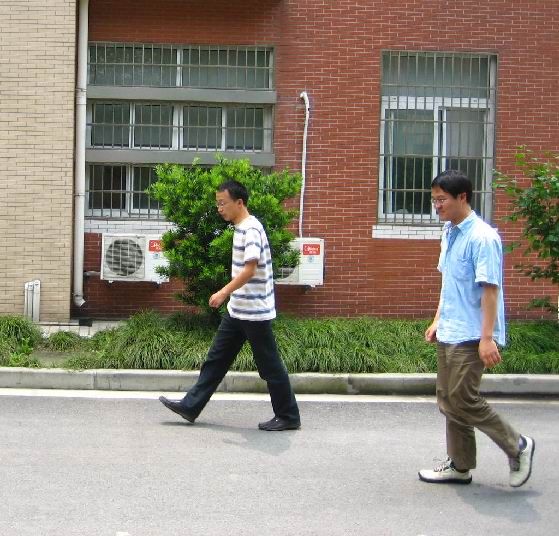

In [6]:
test_img = Image.open('./PennFudanPed/PNGImages/FudanPed00001.png')
test_img

In [41]:
test_img, test_box = dataset[0]

In [42]:
test_box

{'boxes': tensor([[159., 181., 301., 430.],
         [419., 170., 534., 485.]]),
 'labels': tensor([1, 1])}

In [55]:
np_img = test_img.numpy()
np_img = np.transpose(np_img,(1,2,0))
np_img.shape

(536, 559, 3)

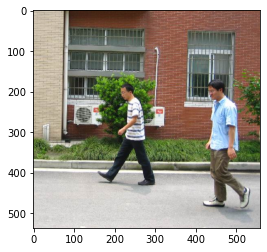

In [56]:
plt.imshow(np_img)

In [45]:
model.eval()
output = model([test_img])

In [47]:
output[0]

{'boxes': tensor([[204.5493, 192.6191, 266.1836, 341.6058],
         [340.1756, 379.2679, 350.3119, 390.6236],
         [420.3492, 196.9376, 487.7811, 380.1985],
         [418.5862, 462.5106, 487.1314, 487.9170],
         [154.0056, 233.4259, 252.2504, 338.1382],
         [162.1318, 268.5782, 261.2207, 374.4939],
         [232.7804, 283.3153, 273.8333, 312.9714],
         [307.8754, 372.2617, 388.2614, 396.2645],
         [236.4054, 292.3021, 267.6871, 304.5783],
         [301.9899,  88.0596, 309.6939,  97.8982],
         [479.2267, 421.7825, 508.5309, 479.9022],
         [283.5146, 143.9879, 303.5211, 252.2677],
         [318.5352, 364.8725, 335.6575, 373.4647],
         [230.4559, 278.0464, 252.6952, 291.5428],
         [226.9757, 266.9806, 259.0596, 300.0352],
         [205.1244, 272.6388, 272.6826, 295.8194],
         [229.4474, 271.3228, 246.6699, 285.3080],
         [132.9714, 262.4048, 295.9582, 308.0838],
         [288.4658, 113.5503, 307.5378, 227.8973],
         [217.3433, 28

In [48]:
predicted = {'boxes':[],'labels':[],'scores':[]}
for label_dict in output:
    s = label_dict['scores']
    for i in range(len(s)):
        if s[i] > 0.8:
            predicted['boxes'].append(label_dict['boxes'][i].tolist())
            predicted['labels'].append(label_dict['labels'][i].tolist())
            predicted['scores'].append(s[i].tolist())
        else:
            #scores should be sorted so we just stop checking after reaching the first elem<0.8
            break
#     for k in label_dict:
#         print("length of k: {}".format(len(label_dict[k])))

In [49]:
predicted

{'boxes': [[204.54928588867188,
   192.61907958984375,
   266.1835632324219,
   341.6058044433594],
  [340.1755676269531, 379.2679138183594, 350.3118896484375, 390.6236267089844],
  [420.34918212890625,
   196.9376220703125,
   487.78106689453125,
   380.198486328125]],
 'labels': [1, 1, 1],
 'scores': [0.8388577699661255, 0.8127906918525696, 0.8023658394813538]}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


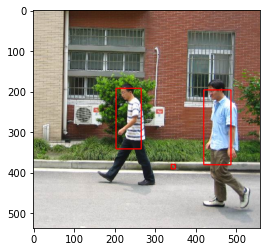

In [63]:
import cv2
# img = Image.open('./ExDark/Bottle/2015_01362.jpg').convert("RGB")
# img = cv2.imread('./ExDark/Bottle/2015_01362.jpg')
color=(255,0,0)
thickness=2

#split() and merge() make it so that cv2.rectangle can take np array as input
r,g,b = cv2.split(np_img)
img_bgr = cv2.merge([r,g,b])
for i in range(len(predicted['boxes'])):
    xmin,ymin,xmax,ymax = predicted['boxes'][i]
    start_point = (int(xmin),int(ymin))
    end_point = (int(xmax),int(ymax))
    img_bgr = cv2.rectangle(img_bgr, start_point, end_point, color, thickness)

plt.imshow(img_bgr);

# Evaluating model after training

Note: will have to move everything with .to(device)

In [8]:
test_img, test_box = dataset[0]
model.eval()
output = model([test_img.to(device)])

In [10]:
output[0]

{'boxes': tensor([[410.6135, 176.5820, 536.4555, 491.2805],
         [154.6160, 196.6818, 305.0392, 425.1930]], device='cuda:0',
        grad_fn=<StackBackward0>),
 'labels': tensor([1, 1], device='cuda:0'),
 'scores': tensor([0.9926, 0.9905], device='cuda:0', grad_fn=<IndexBackward0>)}

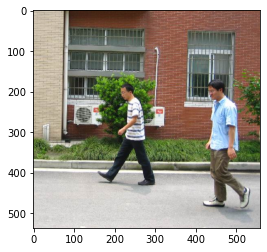

In [14]:
np_img = test_img.numpy()
np_img = np.transpose(np_img,(1,2,0))
plt.imshow(np_img);

In [11]:
predicted = {'boxes':[],'labels':[],'scores':[]}
for label_dict in output:
    s = label_dict['scores']
    for i in range(len(s)):
        if s[i] > 0.8:
            predicted['boxes'].append(label_dict['boxes'][i].tolist())
            predicted['labels'].append(label_dict['labels'][i].tolist())
            predicted['scores'].append(s[i].tolist())
        else:
            #scores should be sorted so we just stop checking after reaching the first elem<0.8
            break
#     for k in label_dict:
#         print("length of k: {}".format(len(label_dict[k])))

In [12]:
predicted

{'boxes': [[410.61346435546875,
   176.5819549560547,
   536.4555053710938,
   491.280517578125],
  [154.61602783203125,
   196.68182373046875,
   305.0391540527344,
   425.1929626464844]],
 'labels': [1, 1],
 'scores': [0.9925746917724609, 0.9905202388763428]}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


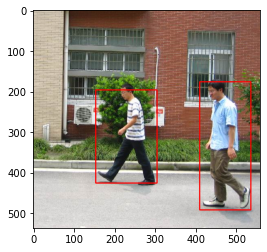

In [15]:
import cv2
color=(255,0,0)
thickness=2
r,g,b = cv2.split(np_img)
img_bgr = cv2.merge([r,g,b])
for i in range(len(predicted['boxes'])):
    xmin,ymin,xmax,ymax = predicted['boxes'][i]
    start_point = (int(xmin),int(ymin))
    end_point = (int(xmax),int(ymax))
    img_bgr = cv2.rectangle(img_bgr, start_point, end_point, color, thickness)

plt.imshow(img_bgr);